In [78]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from surprise import Reader, Dataset as SurpriseDataset
from sklearn import preprocessing
from surprise import SVD, NMF, KNNWithMeans, evaluate, GridSearch
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from surprise.model_selection import cross_validate
import warnings
from collections import defaultdict
import torch
from fastai.learner import *
from fastai.column_data import *
from fastai.imports import *
warnings.filterwarnings('ignore')

### Book-Crossing Dataset

In [5]:
#loading data
df_br = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = "ISO-8859-1")
df_br.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
##Preprocessing 
df_br.ISBN = df_br.ISBN.str.replace(r'[^\w\d]+', '')
le = preprocessing.LabelEncoder()
le.fit(df['ISBN'])
df_br.ISBN = le.transform(df['ISBN']) 

# Replaced the zero rating with the average rating and remove zero rating books
avg_ratings = df_br.groupby('ISBN')['Book-Rating'].mean().round().astype(np.int8)
df_br.loc[df['Book-Rating'] == 0, 'Book-Rating'] = df_br.loc[df_br['Book-Rating'] == 0, 'ISBN'].map(avg_ratings)
df_br = df_br[df_br['Book-Rating'] != 0]

In [7]:
df_br.sample(5)

,User-ID,ISBN,Book-Rating
257992,59820,121100,6
489875,116605,169531,7
267225,61845,214617,2
208674,48313,164306,2
536237,129358,64058,3


In [8]:
df_br.describe()

,User-ID,ISBN,Book-Rating
count,923737.000000,923737.000000,923737.000000
mean,138885.071174,134982.640115,5.042225
std,80605.266431,84248.193255,2.844468
min,8.000000,0.000000,1.000000
25%,69355.000000,73920.000000,3.000000
50%,138198.000000,117966.000000,4.000000
75%,209373.000000,187724.000000,8.000000
max,278854.000000,340555.000000,10.000000


In [22]:
data_br = SurpriseDataset.load_from_df(df_br, reader=Reader(rating_scale=(1, 10)))

#### Grid Search

In [ ]:
#grid search for SVD hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(data_br)

In [ ]:
#grid search for NMF hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE'])
grid_search.evaluate(data_br)

#### SVD

In [16]:
algo = SVD(n_factors=100, n_epochs=30, lr_all=0.005, reg_all=0.03)
cross_validate(algo, data_br, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6479  1.6461  1.6516  1.6485  0.0023  
Fit time          89.90   95.09   82.65   89.21   5.10    
Test time         5.38    4.91    3.74    4.68    0.69    


#### NMF

In [54]:
algo = NMF(n_factors=30, n_epochs=50, reg_pu=0.5, reg_qi=0.05)
cross_validate(algo, data_br, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.4404  2.4532  2.4369  2.4435  0.0070  
Fit time          0.55    0.58    0.61    0.58    0.03    
Test time         0.02    0.02    0.01    0.02    0.00    


#### KNNwithMeans

In [55]:
algo = KNNWithMeans(k=40)
cross_validate(algo, data_br2, measures=['RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8602  1.8512  1.8627  1.9780  0.0049  
Fit time          0.08    0.07    0.05    0.07    0.01    
Test time         0.02    0.02    0.02    0.02    0.00    


#### Fast.ai

In [96]:
df_br = df_br.astype(float)
val_indx = get_cv_idxs(len(df_br))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors
cf = CollabFilterDataset.from_data_frame('.', df_br, 'User-ID', 'ISBN', 'Book-Rating')
cf.users = cf.users.astype(float)

learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

#prediction on validation
preds = learn.predict() 
y=learn.data.val_y
print(' Mean squared error on predictions = ', math.sqrt(metrics.mean_squared_error(y,preds)))

 Mean squared error on predictions =  1.8569


### MovieLens Dataset

In [40]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

In [45]:
len(ratings), ratings.user_id.unique().size, ratings.movie_id.unique().size

(100000, 943, 1682)

In [46]:
ratings.sample(5)

,user_id,movie_id,rating,unix_timestamp
57542,269,663,4,891449880
83619,936,1190,3,886833707
21564,44,1,4,878341315
15062,377,323,2,891297001
99514,732,269,5,882589593


In [47]:
ratings.describe()

,user_id,movie_id,rating,unix_timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [52]:
data_ml = SurpriseDataset.load_from_df(ratings[ratings.columns[0:3]] , reader=Reader(rating_scale=(1, 5)))

In [ ]:
#grid search for hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(data_ml)

In [ ]:
#grid search for hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE'])
grid_search.evaluate(data_ml)

#### SVD

In [57]:
algo = SVD(n_factors=50, n_epochs=15, lr_all=0.002, reg_all=0.02)
cross_validate(algo, data_ml, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9444  0.9477  0.9435  0.9452  0.0018  
Fit time          3.01    2.96    4.57    3.51    0.75    
Test time         0.45    0.30    0.36    0.37    0.06    


#### NMF

In [59]:
algo = NMF(n_factors=15, n_epochs=50, reg_pu=0.02, reg_qi=0.02)
cross_validate(algo, data_ml, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9737  0.9702  0.9760  0.9733  0.0024  
Fit time          0.37    0.36    0.35    0.36    0.01    
Test time         0.01    0.01    0.01    0.01    0.00    


#### KNNwithMeans

In [62]:
algo = KNNWithMeans(k=20)
cross_validate(algo, data_ml, measures=['RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9536  0.9609  0.9526  0.9557  0.0037  
Fit time          0.50    1.01    0.85    0.79    0.21    
Test time         6.24    8.51    7.63    7.46    0.94    


#### Fast.ai

In [97]:
ratings = ratings[ratings.columns[0:3]]
ratings = ratings.astype(float)
val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 1e-4 # weight decay
n_factors = 50 # n_factors
cf = CollabFilterDataset.from_data_frame('.', ratings, 'user_id', 'movie_id', 'rating')
cf.users = cf.users.astype(float)

learn = cf.get_learner(n_factors, val_indx, bs=32, opt_fn=optim.Adam)
learn.fit(1e-2,5, wds = wd, cycle_len=1, cycle_mult=2)

#prediction on validation
preds = learn.predict() 
y=learn.data.val_y
print(' Mean squared error on predictions = ', math.sqrt(metrics.mean_squared_error(y,preds)))

 Mean squared error on predictions =  0.87488


### Jester Dataset

In [66]:
df_jester = pd.read_csv('jester_ratings.csv')

In [67]:
df_jester.sample(5)

,user_id,joke_id,rating
619937,36087,13,-3.281
201980,52448,124,9.062
222448,42072,19,-1.938
798012,38087,150,-0.688
341176,63759,48,0.188


In [68]:
df_jester.describe() 

,user_id,joke_id,rating
count,1000000.000000,1000000.000000,1000000.000000
mean,32737.979550,70.710539,1.618454
std,18282.777812,46.004394,5.303466
min,1.000000,5.000000,-10.000000
25%,17217.000000,21.000000,-2.031000
50%,34837.000000,69.000000,2.250000
75%,47302.000000,112.000000,5.719000
max,63978.000000,150.000000,10.000000


In [70]:
data_jst = SurpriseDataset.load_from_df(df_jester, reader=Reader(rating_scale=(-10, 10)))

#### Grid Search

In [ ]:
#grid search for SVD hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(data_jst)

In [ ]:
#grid search for NMF hyperparameters
param_grid = {'lr_all': [0.001, 0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.1, 0.2, 0.3, 0.4]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE'])
grid_search.evaluate(data_jst)

#### SVD

In [16]:
algo = SVD(n_factors=100, n_epochs=20, lr_all=0.001, reg_all=0.02)
cross_validate(algo, data_jst, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    4.3871  4.3857  4.3769  4.3833  0.0045  
Fit time          89.90   95.09   82.65   89.21   5.10    
Test time         5.38    4.91    3.74    4.68    0.69    


#### NMF

In [54]:
algo = NMF(n_factors=40, n_epochs=50, reg_pu=0.6, reg_qi=0.06)
cross_validate(algo, data_jst, measures=['RMSE'], cv=3, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    7.4298  7.4325  7.3367  7.3997  0.0445  
Fit time          0.55    0.58    0.61    0.58    0.03    
Test time         0.02    0.02    0.01    0.02    0.00    


#### KNNWithMeans

In [62]:
algo = KNNWithMeans(k=40)
cross_validate(algo, data_jst, measures=['RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    5.1290  5.1470  5.1131  5.1297  0.0138  
Fit time          0.50    1.01    0.85    0.79    0.21    
Test time         6.24    8.51    7.63    7.46    0.94    


#### Fast.ai

In [98]:
df_jester = df_jester.astype(float)
val_indx = get_cv_idxs(len(df_jester))  # index for validation set
wd = 1e-4 # weight decay
n_factors = 20 # n_factors
cf = CollabFilterDataset.from_data_frame('.', df_jester, 'user_id', 'joke_id', 'rating')
cf.users = cf.users.astype(float)

learn = cf.get_learner(n_factors, val_indx, bs=32, opt_fn=optim.Adam)
learn.fit(1e-2,5, wds = wd, cycle_len=1, cycle_mult=2)

#prediction on validation
preds = learn.predict() 
y=learn.data.val_y
print(' Mean squared error on predictions = ', math.sqrt(metrics.mean_squared_error(y,preds)))

 Mean squared error on predictions =  5.358969


## Example Recommendations

In [73]:
def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [74]:
trainset = data_ml.build_full_trainset()
algo = SVD()
algo.train(trainset)

In [75]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [80]:
top_n = get_top_n(predictions, n=10)

In [93]:
# Prediction for user_id = 68
top_pred = pd.DataFrame.from_dict(top_n[68])
top_pred.columns = ['movie_id', 'prediction']
top_pred

,movie_id,prediction
0,173,4.446725
1,318,4.441936
2,12,4.430570
3,172,4.348763
4,483,4.318119
5,174,4.293846
6,14,4.273068
7,408,4.269838
8,527,4.243179
9,64,4.229018


## Comparison

In [94]:
# Results from RMSE scores

#KMeans
Kme = (1.9780, 0.9557, 5.1297 )

#SVD

SVDM = (1.6485, 0.9452, 4.3833)

#DL

DL = (1.8569, 0.76542, 5.358969)

#NMF

NMF = (2.4435, 0.9733, 7.3997)

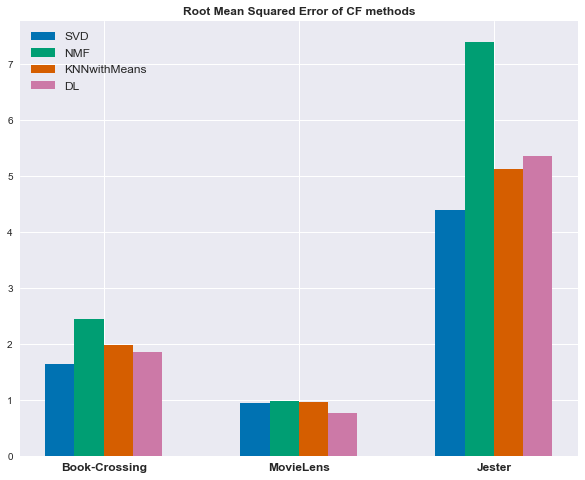

In [95]:
N = 3
fig, ax = plt.subplots(figsize=(10,8))

c = sns.color_palette(palette='colorblind', n_colors=4)

ind = np.arange(N)    # the x locations for the groups
width = 0.15         # the width of the bars
p1 = ax.bar(ind, SVDM, width, color=c[0], bottom=0)

p2 = ax.bar(ind+ width, NMF, width, color=c[1], bottom=0)

p3 = ax.bar(ind+ width*2, Kme, width, color=c[2], bottom=0)

p4 = ax.bar(ind+ width*3, DL, width, color=c[3], bottom=0)


ax.set_title('Root Mean Squared Error of CF methods', weight='semibold')
ax.set_xticks(ind + width*1.5)
ax.set_xticklabels(('Book-Crossing', 'MovieLens', 'Jester'), weight='semibold', size='medium')

ax.legend((p1[0], p2[0], p3[0], p4[0]), ('SVD', 'NMF', 'KNNwithMeans', 'DL'), fontsize='medium')